In [1]:
# ==============imports===================
from os import listdir
from os.path import isfile, join
import json
from typing import Dict, List, Tuple, Set, Optional, Any

import plotly.graph_objects as go
from collections import Counter

import pycountry

import numpy as np
from tqdm import tqdm
import pickle
import os
import random
from pathlib import Path


import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# ==================args=====================
# checkpoints = None
checkpoints = ['best', '1000', '10000', '50000', '100000', '150000', '200000', '250000', '300000']
random_baseline = False
embedding_size = 2048
top_k = 50
attributes = ['Gender', 'Number', 'POS']
colors = {'Gender':'b', 'Number':'g', 'POS':'r'}
# attributes = ['Aspect', 'Case', 'Definiteness', 'Finiteness', 'Gender', 'Mood', 'Number',\
#              'Person', 'POS', 'Tense', 'Voice']
language = None
show_plot = False
experiment_name = 'inter-layer-17'
# layers = [1, 5, 9, 13, 17, 21, 25]
layers = None
model = 'bloom-1b7'

In [3]:
# =================functions====================
def convert_language_code(treebank_name):
    """ Converts treebank names to language codes. """
    lang_name = treebank_name[3:].split("-")[0].replace("_", " ")
    lang = pycountry.languages.get(name=lang_name)

    if lang is not None:
        return lang.alpha_3.lower()

    return "unk"

def compute_overlap(data_raw, top_k):
    mark_count: Dict[str, int] = {}  # num of languages logging that attribute
    results: Dict[str, Counter] = {}
    for run_config, dims in data_raw:
        if run_config["embedding"] != embedding:
            continue

        # Increment mark counting
        if run_config["attribute"] not in mark_count:
            mark_count[run_config["attribute"]] = 0

        mark_count[run_config["attribute"]] += 1

        # Increment actual counters
        if run_config["attribute"] not in results:
            results[run_config["attribute"]] = Counter()

        results[run_config["attribute"]].update(dims[:top_k])

    return results, mark_count


def compute_similarity_for_attribute(attribute, data_raw, top_k, language_order: Optional[List[str]] = None):
    data_list: List[Tuple[str, Set[int]]] = []
    for run_config, dims in data_raw:
        if run_config["embedding"] != embedding:
            continue

        if run_config["attribute"] != attribute:
            continue

        data_list.append((run_config["language"], set(dims[:top_k])))

    if not language_order:
        data_list = sorted(data_list, key=lambda x: x[0])
        return [x[0] for x in data_list], compute_similarity(data_list)
    else:
        data_list_dict = {k: v for k, v in data_list}
        data_list_sorted = []
        for x in language_order:
            if x in data_list_dict:
                data_list_sorted.append((x, data_list_dict[x]))

        data_list = data_list_sorted
        return [x[0] for x in data_list], compute_similarity(data_list)


def compute_similarity_for_language(language, data_raw, top_k):
    data_list: List[Tuple[str, Set[int]]] = []
    for run_config, dims in data_raw:
        if run_config["embedding"] != embedding:
            continue

        if run_config["language"] != language:
            continue

        data_list.append((run_config["attribute"], set(dims[:top_k])))

    data_list = sorted(data_list, key=lambda x: x[0])

    return [x[0] for x in data_list], compute_similarity(data_list)


def compute_jaccard_index(set_a: Set[int], set_b: Set[int]) -> float:
    return len(set_a & set_b) / len(set_a | set_b)


def compute_overlap_coefficient(set_a: Set[int], set_b: Set[int]) -> float:
    return len(set_a & set_b) / min(len(set_a), len(set_b))


def compute_similarity(data_list: List[Tuple[str, Set[int]]]):
    num_items = len(data_list)
    similarity_array = np.zeros((num_items, num_items))
    extra_data = {
        "overlap": np.empty((num_items, num_items), dtype=list),
        "overlap_num": np.zeros((num_items, num_items)),
    }
    for idx_a, (group_a, dim_set_a) in enumerate(data_list):
        for idx_b, (group_b, dim_set_b) in enumerate(data_list):
            similarity_array[idx_a, idx_b] = compute_overlap_coefficient(dim_set_a, dim_set_b)
            extra_data["overlap"][idx_a, idx_b] = sorted(list(set(dim_set_a & dim_set_b)))
            extra_data["overlap_num"][idx_a, idx_b] = len(dim_set_a & dim_set_b)

    return similarity_array, extra_data


def compute_pvalues(overlap_num_matrix: np.array, p_val_dict: Dict[int, float]) -> np.array:
    return np.vectorize(lambda x: p_val_dict[int(x)])(overlap_num_matrix)


def build_statistical_significance_matrix(p_values_matrix, alpha=0.05, method="bonferroni", symmetry=False):
    num_rows = p_values_matrix.shape[0]
    num_hypotheses = int(num_rows * (num_rows + 1) / 2) - num_rows
    num_hypotheses = num_hypotheses if num_hypotheses > 0 else 999
    alpha_bonferroni = alpha / num_hypotheses

    if method == "bonferroni":
        mask = np.tril(np.ones_like(p_values_matrix, dtype=bool), k=-1)
        significance_matrix = (p_values_matrix < alpha_bonferroni) * mask
    elif method == "holm-bonferroni":
        mask = np.triu(np.ones_like(p_values_matrix)) * 9999.0
        p_values_matrix += mask
        p_values_matrix_flat = p_values_matrix.reshape(-1)
        sorting_indices = p_values_matrix_flat.argsort()
        unsorting_indices = sorting_indices.argsort()

        sorted_p_values = p_values_matrix_flat[sorting_indices][:num_hypotheses]
        alpha_holm = np.arange(1.0, num_hypotheses + 1.0)[::-1] ** -1 * alpha

        broke = False
        for k, (pval, alph) in enumerate(zip(sorted_p_values.tolist(), alpha_holm.tolist())):
            if pval > alph:
                broke = True
                break

        if not broke:
            # Needed in case we never accepted the null hypothesis
            k += 1

        # k will be equal to the first index where we do NOT reject the null hypothesis.
        # So we can accept the alternative hypothesis on all indices less than k
        # e.g., if k == 0, we always accept the null hypothesis. If k == num_hypothesis
        # we always reject the null hypothesis.
        rejected_null_sorted = [True if idx < k else False for idx in range(num_hypotheses)]

        # Pad remaining list with rejections
        rejected_null_sorted.extend([False] * (num_rows ** 2 - num_hypotheses))

        # Reverse sort
        significance_matrix = np.array(rejected_null_sorted)[unsorting_indices].reshape(num_rows, num_rows)

    if symmetry:
        # Mirror along diagonal
        significance_matrix = significance_matrix | significance_matrix.T

    return significance_matrix


def build_annotations_list(annotation_matrix):
    n = annotation_matrix.shape[0]
    annotation_list = []
    for x in range(n):
        for y in range(n):
            if not annotation_matrix[x][y]:
                continue

            if x == y:
                continue

            annotation_list.append(
                dict(
                    x=x / n, y=y / n,
                    xref='paper',
                    yref='paper',
                    text="■",
                    showarrow=False,
                    xanchor="left",
                    yanchor="bottom",
                    font=dict(color="rgb(236,136,106)")
                )
            )

    return annotation_list


Loop over checkpoints
{0: 1.0, 1: 0.714267, 2: 0.346443, 3: 0.120593, 4: 0.031809, 5: 0.006642, 6: 0.001103, 7: 0.000161, 8: 2.2e-05, 9: 2e-06, 10: 1e-06, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0}
8
[[1.   0.14 0.14 0.16 0.06 0.18 0.18 0.02]
 [0.14 1.   0.28 0.24 0.08 0.3  0.3  0.04]
 [0.14 0.28 1.   0.22 0.06 0.42 0.36 0.04]
 [0.16 0.24 0.22 1.   0.06 0.32 0.3  0.  ]
 [0.06 0.08 0.06 0.06 1.   0.1  0.14 0.  ]
 [0.18 0.3  0.42 0.32 0.1  1.   0.46 0.  ]
 [0.18 0.3  0.36 0.3  0.14 0.46 1.   0.02]
 [0.02 0.04 0.04 0.   0.   0.   0.02 1.  ]]
10
[[1.   0.12 0.18 0.04 0.08 0.1  0.14 0.06 0.04 0.06]
 [0.12 1.   0.32 0.06 0.26 0.1  0.34 0.28 0.08 0.18]
 [0.18 0.32 1.   0.08 0.2  0.

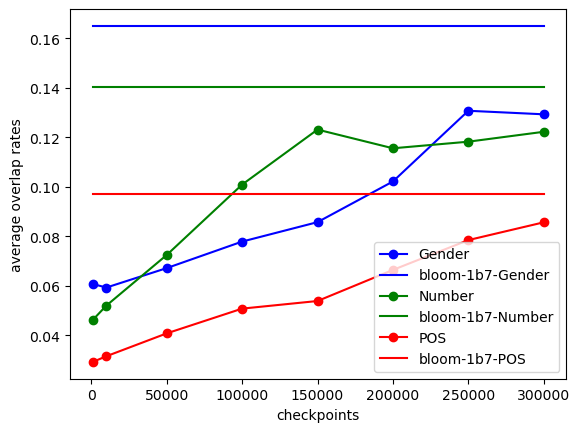

In [4]:
# Dict{attr: Dict{checkpoint: avg_overlap_rate}}
avg_overlap_rates: Dict[str, Dict[str, float]] = defaultdict(dict)

if layers is not None:
    print("Loop over layers")
    for layer in layers:
        embedding = model
        experiment_name = f"inter-layer-{layer}"
        if layer == 25:
            experiment_name = "last-layer"
        DEFAULT_RESULTS_FOLDER = f"results/{embedding}/{experiment_name}"

        # print(listdir(DEFAULT_RESULTS_FOLDER))
        RESULTS = []
        rel_treebanks = []
        for lang in listdir(DEFAULT_RESULTS_FOLDER):
            if lang == 'UD_Chinese-CFL':
                continue
            rel_treebanks.append(lang)
            for attr in listdir(join(DEFAULT_RESULTS_FOLDER, lang)):
                RESULTS.append((lang, attr))
                
        # embedding, attribute, language

        DEFAULT_FILE_FORMAT = join(DEFAULT_RESULTS_FOLDER, "{lang}/{attribute}/loginfo.json")

        results_raw: List[Tuple[Dict[str, Any], List[int]]] = []

        for l, a in RESULTS:  # noqa
            if l in rel_treebanks:
                with open(DEFAULT_FILE_FORMAT.format(lang=l, attribute=a), "r") as h:
                    data = json.load(h)

                results_raw.append(
                    (
                        { "embedding": embedding, "attribute": a,
                        "language": convert_language_code(l) },
                        [d["iteration_dimension"] for d in data if "iteration_dimension" in d]
                        if not random_baseline else random.sample(range(embedding_size), k=top_k)
                    )
            )
        # Compute p values
        num_permutations = 1000000
        p_vals_cache_file = f"{embedding}_{top_k}_{num_permutations}_pvals.pkl"
        if not os.path.exists(p_vals_cache_file):
            # Compute p-values for different similarities
            # if embedding in ["bert-base-multilingual-cased", "xlm-roberta-base"]:
            #     dimensionality = 768
            # elif embedding == "xlm-roberta-large":
            #     dimensionality = 1024
            # elif 'bloom' in embedding:
            #     dimensionality = 1024
            # else:
            #     raise Exception("Embedding does not exist")
            #     dimensionality = 300
            dimensionality = embedding_size

            reference_order = random.sample(list(range(dimensionality)), dimensionality)
            reference_top_k = reference_order[:top_k]
            similarities = []

            for i in tqdm(range(num_permutations)):
                permuted_top_k = random.sample(reference_order, top_k)
                similarities.append(compute_overlap_coefficient(set(reference_top_k), set(permuted_top_k)))
                pvals = {}

            for i in range(top_k + 1):
                observed_hypothesis = i / top_k  # What is overlap score greater than or equal to?
                permutations_match = [s for s in similarities if s >= observed_hypothesis]
                pval = len(permutations_match) / num_permutations
                print(f"P-value when sim >= {observed_hypothesis} (overlap >= {i} dims): {pval:.5f}")
                pvals[i] = pval

            with open(p_vals_cache_file, "wb") as h:
                pickle.dump(pvals, h)
        else:
            with open(p_vals_cache_file, "rb") as h:
                pvals = pickle.load(h)

        print(repr(pvals))

        for attr in attributes:
            labels, (similarity_matrix, extra_data) = compute_similarity_for_attribute(
                attr, results_raw, top_k)
            
            # get the average pairwise overlap:
            print(len(labels))
            print(similarity_matrix)
            avg_overlap_rates[attr][layer] = np.average(similarity_matrix[np.triu_indices(len(labels), k = 1)])
            

            x_labels = labels
            y_labels = labels

            p_values_matrix = compute_pvalues(extra_data["overlap_num"], pvals)
            annotation_matrix = build_statistical_significance_matrix(
                p_values_matrix, alpha=0.05, method="holm-bonferroni", symmetry=True)
    
    for attr, overlap_rates in avg_overlap_rates.items():
        overlap_rates = sorted(overlap_rates.items()) 
        print(overlap_rates)
        x, y = zip(*overlap_rates)
        
        plt.plot(x, y, f'o-', label=attr)

    plt.legend()
    plt.xlabel("layer")
    plt.ylabel('average overlap rates')

    plt.savefig(f'experiments/scatterplots/{model}/layers.pdf')


elif checkpoints is not None:
    print("Loop over checkpoints")
    for checkpoint in checkpoints:
        embedding = f"{model}-intermediate-global_step{checkpoint}"
        if checkpoint == 'best':
            embedding = model
        DEFAULT_RESULTS_FOLDER = f"results/{embedding}/{experiment_name}"

        # print(listdir(DEFAULT_RESULTS_FOLDER))
        RESULTS = []
        rel_treebanks = []
        for lang in listdir(DEFAULT_RESULTS_FOLDER):
            if lang == 'UD_Chinese-CFL':
                continue
            rel_treebanks.append(lang)
            for attr in listdir(join(DEFAULT_RESULTS_FOLDER, lang)):
                RESULTS.append((lang, attr))
                
        # embedding, attribute, language

        DEFAULT_FILE_FORMAT = join(DEFAULT_RESULTS_FOLDER, "{lang}/{attribute}/loginfo.json")

        results_raw: List[Tuple[Dict[str, Any], List[int]]] = []

        for l, a in RESULTS:  # noqa
            if l in rel_treebanks:
                with open(DEFAULT_FILE_FORMAT.format(lang=l, attribute=a), "r") as h:
                    data = json.load(h)

                results_raw.append(
                    (
                        { "embedding": embedding, "attribute": a,
                        "language": convert_language_code(l) },
                        [d["iteration_dimension"] for d in data if "iteration_dimension" in d]
                        if not random_baseline else random.sample(range(embedding_size), k=top_k)
                    )
            )
        # Compute p values
        num_permutations = 1000000
        p_vals_cache_file = f"{embedding}_{top_k}_{num_permutations}_pvals.pkl"
        if not os.path.exists(p_vals_cache_file):
            # Compute p-values for different similarities
            # if embedding in ["bert-base-multilingual-cased", "xlm-roberta-base"]:
            #     dimensionality = 768
            # elif embedding == "xlm-roberta-large":
            #     dimensionality = 1024
            # elif 'bloom' in embedding:
            #     dimensionality = 1024
            # else:
            #     raise Exception("Embedding does not exist")
            #     dimensionality = 300
            dimensionality = embedding_size

            reference_order = random.sample(list(range(dimensionality)), dimensionality)
            reference_top_k = reference_order[:top_k]
            similarities = []

            for i in tqdm(range(num_permutations)):
                permuted_top_k = random.sample(reference_order, top_k)
                similarities.append(compute_overlap_coefficient(set(reference_top_k), set(permuted_top_k)))
                pvals = {}

            for i in range(top_k + 1):
                observed_hypothesis = i / top_k  # What is overlap score greater than or equal to?
                permutations_match = [s for s in similarities if s >= observed_hypothesis]
                pval = len(permutations_match) / num_permutations
                print(f"P-value when sim >= {observed_hypothesis} (overlap >= {i} dims): {pval:.5f}")
                pvals[i] = pval

            with open(p_vals_cache_file, "wb") as h:
                pickle.dump(pvals, h)
        else:
            with open(p_vals_cache_file, "rb") as h:
                pvals = pickle.load(h)

        print(repr(pvals))

        for attr in attributes:
            labels, (similarity_matrix, extra_data) = compute_similarity_for_attribute(
                attr, results_raw, top_k)
            
            # get the average pairwise overlap:
            print(len(labels))
            print(similarity_matrix)
            if checkpoint == 'best':
                avg_overlap_rates[attr][checkpoint] = np.average(similarity_matrix[np.triu_indices(len(labels), k = 1)])
            else:
                avg_overlap_rates[attr][int(checkpoint)] = np.average(similarity_matrix[np.triu_indices(len(labels), k = 1)])

            x_labels = labels
            y_labels = labels

            p_values_matrix = compute_pvalues(extra_data["overlap_num"], pvals)
            annotation_matrix = build_statistical_significance_matrix(
                p_values_matrix, alpha=0.05, method="holm-bonferroni", symmetry=True)
    
    for attr, overlap_rates in avg_overlap_rates.items():
        rate_for_best_checkpoint = [overlap_rates['best']]*8
        del overlap_rates['best']
        print(overlap_rates)
        overlap_rates = sorted(overlap_rates.items()) 
        print(overlap_rates)
        x, y = zip(*overlap_rates)
        
        color = colors[attr]
        print(x)
        print(y)
        plt.plot(x, y, f'o-{color}', label=attr)
        plt.plot(x, rate_for_best_checkpoint, f'-{color}', label=f'{model}-{attr}')

    plt.legend()
    plt.xlabel("checkpoints")
    plt.ylabel('average overlap rates')

    plt.savefig(f'experiments/scatterplots/{model}/checkpoints_{experiment_name}.pdf')

    
else: 
    print("no x axises. please check.")

